In [5]:
import warnings
def fxn(): 
	warnings.warn("deprecated",DeprecationWarning)

with warnings.catch_warnings( ):
    warnings.simplefilter("ignore")
    fxn( )

import numpy as np
import h5py

In [6]:
# Load data
A01T = h5py.File('data/A01T_slice.mat', 'r')
X = np.copy(A01T['image'])
y = np.copy(A01T['type'])
y = y[0,0:X.shape[0]:1]
y = np.asarray(y, dtype=np.int32)
X = np.nan_to_num(X)
print(X.shape)
print(y.shape)

(288, 25, 1000)
(288,)


In [14]:
# Preprocess Input
y -= 769
# Split data into Train, test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 
print(X_train.shape)

(230, 25, 1000)


In [4]:

from keras.utils import np_utils
one_hot_train = np_utils.to_categorical(y_train, 4)
one_hot_test = np_utils.to_categorical(y_test, 4)


Using TensorFlow backend.


In [11]:
from keras.models import Sequential
from keras.layers import BatchNormalization, MaxPooling2D, Permute, Flatten, Softmax, Dense, Dropout, Conv1D, Conv2D, Conv2DTranspose, AveragePooling1D, AveragePooling2D, Activation, Reshape
from keras.backend import permute_dimensions

Using TensorFlow backend.


In [ ]:
# Naive implementation
num_layers = 2
model = Sequential()
for _ in np.arange(num_layers):
    model.add(Conv1D(filters = 20, kernel_size = 10, activation = 'elu', input_shape = (1000,22)))
model.add(AveragePooling1D(pool_size=(75), strides=(15)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=4, activation = 'softmax'))


from keras.optimizers import Adam
Adam = Adam(lr=0.15)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



X_train = X_train.transpose((0,2,1))
X_train = X_train[:, :, 0:22]

X_test = X_test.transpose((0,2,1))
X_test = X_test[:, :, 0:22]


model.fit(X_train , one_hot_train, epochs=30, batch_size=32)
score = model.evaluate(X_test, one_hot_test, verbose=0)
print(score)


In [6]:
# Deep Implementation CNN

model = Sequential()

# Conv Pool Block 1
model.add(Conv2D(filters=25, kernel_size=(10,1), input_shape=(1000, 22, 1), strides=1, data_format="channels_last"))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
          
model.add(Conv2D(filters = 25, kernel_size = (1,22), activation = 'elu'))
model.add(Permute((1,3,2)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))
print(model.output_shape)

# Conv Pool Block 2
model.add(Conv2D(filters = 50, kernel_size = (10,25), activation = 'elu'))
model.add(Permute((1,3,2)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))
print(model.output_shape)

# Conv Pool Block 3
model.add(Conv2D(filters = 100, kernel_size = (10,50), activation = 'elu'))
model.add(Permute((1,3,2)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))
print(model.output_shape)

# Conv Pool Block 4
model.add(Conv2D(filters = 200, kernel_size = (10,100), activation = 'elu'))
model.add(Permute((1,3,2)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))
print(model.output_shape)

# Dense Layers
model.add(Flatten())
model.add(Dense(units=4, kernel_initializer='glorot_normal', activation = 'softmax'))
print(model.output_shape)











(None, 330, 25, 1)
(None, 107, 50, 1)
(None, 32, 100, 1)
(None, 7, 200, 1)
(None, 4)


In [ ]:
# Shallow CNN
model = Sequential()
model.add(Conv2D(filters=40, kernel_size=(22,1), activation='elu', input_shape=(1000, 22, 1), strides=1, data_format="channels_last"))
print(model.output_shape)
model.add(Permute((3, 2, 1)))
print(model.output_shape)
model.add(Conv2D(filters=40, kernel_size=(22, 1), activation='elu', data_format="channels_first"))
print(model.output_shape)
model.add(Permute((3, 2, 1)))
print(model.output_shape)
model.add(AveragePooling2D(pool_size=(75,1), strides=(15,1)))
print(model.output_shape)
model.add(Flatten())
model.add(Dense(units=4, kernel_initializer='glorot_normal', activation = 'softmax'))
print(model.output_shape)

In [8]:
from keras.optimizers import Adam
Adam = Adam(lr=0.15)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(X_train.transpose(0,2,1)[:, :, 0:22, None], one_hot_train, epochs=50, batch_size=32)

Epoch 1/50
230/230 [==============================] - 8s 35ms/step - loss: 4.1340 - acc: 0.2348
Epoch 2/50
230/230 [==============================] - 7s 28ms/step - loss: 2.2076 - acc: 0.2783
Epoch 3/50
230/230 [==============================] - 7s 28ms/step - loss: 1.9284 - acc: 0.2870
Epoch 4/50
230/230 [==============================] - 6s 27ms/step - loss: 1.7634 - acc: 0.3261
Epoch 5/50
230/230 [==============================] - 6s 28ms/step - loss: 1.7621 - acc: 0.3130
Epoch 6/50
230/230 [==============================] - 8s 33ms/step - loss: 1.7926 - acc: 0.2696
Epoch 7/50
230/230 [==============================] - 8s 34ms/step - loss: 1.5169 - acc: 0.3652
Epoch 8/50
230/230 [==============================] - 7s 30ms/step - loss: 1.6196 - acc: 0.4087
Epoch 9/50
230/230 [==============================] - 7s 29ms/step - loss: 1.5430 - acc: 0.4087
Epoch 10/50
230/230 [==============================] - 7s 29ms/step - loss: 1.5359 - acc: 0.4000
Epoch 11/50
230/230 [==================

In [ ]:
X_train = X_train.transpose((0,2,1))
X_train = X_train[:, :, 0:22, None]

X_test = X_test.transpose((0,2,1))
X_test = X_test[:, :, 0:22, None]

In [ ]:

score = model.evaluate(X_test, one_hot_test, verbose=0)
print(score)


(None, 979, 22, 40)
(None, 40, 22, 979)
(None, 40, 1, 979)
(None, 979, 1, 40)
(None, 61, 1, 40)
(None, 4)
Train on 182 samples, validate on 46 samples
Epoch 1/10
182/182 [==============================] - 10s 57ms/step - loss: 1.3907 - acc: 0.2857 - val_loss: 1.3482 - val_acc: 0.3261
Epoch 2/10
182/182 [==============================] - 10s 55ms/step - loss: 1.3060 - acc: 0.4560 - val_loss: 1.3361 - val_acc: 0.3043
Epoch 3/10
182/182 [==============================] - 11s 58ms/step - loss: 1.2333 - acc: 0.4780 - val_loss: 1.3225 - val_acc: 0.3043
Epoch 4/10
182/182 [==============================] - 10s 55ms/step - loss: 1.1932 - acc: 0.4835 - val_loss: 1.3426 - val_acc: 0.3478
Epoch 5/10
182/182 [==============================] - 10s 56ms/step - loss: 1.1642 - acc: 0.5055 - val_loss: 1.3621 - val_acc: 0.3478
Epoch 6/10
182/182 [==============================] - 11s 62ms/step - loss: 1.1234 - acc: 0.5549 - val_loss: 1.3607 - val_acc: 0.2609
Epoch 7/10
182/182 [=========================

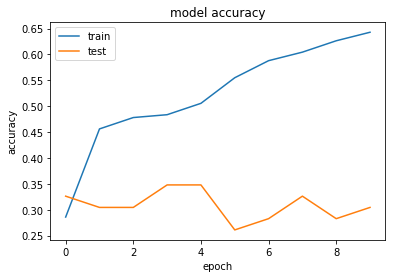

60/60 [==============================] - 1s 25ms/step
[1.3829423189163208, 0.30000001192092896]
0.2765884637832642


In [26]:
from sklearn.model_selection import StratifiedKFold
import keras
from sklearn import preprocessing
import matplotlib.pyplot as plt
num_folds = 5
def stratified_train_test_split(X, y, k):
    ''' Returns a stratified train/test split, for k number of splits.
    Return value is in the form [(train indices, test indices), ... for k folds ]
    '''
    skf = StratifiedKFold(n_splits=k)
    return skf.split(X, y)

tt_splits = stratified_train_test_split(X, y, num_folds)
y_cat = keras.utils.to_categorical(y, num_classes=4)

batch_size = 128
num_epochs = 10
val_split = 0.2
avg_acc = 0
for train_idx, test_idx in tt_splits:
    X_train = X[train_idx]
    y_train = y_cat[train_idx]
    X_test = X[test_idx]
    y_test = y_cat[test_idx]
    
    X_train = X_train.transpose((0,2,1))
    X_train = X_train[:, :, 0:22, None]

    X_test = X_test.transpose((0,2,1))
    X_test = X_test[:, :, 0:22, None]
    
    temp = np.reshape(X_train, (X_train.shape[0], -1))
    X_train = np.reshape(preprocessing.scale(temp), X_train.shape)
    
    temp = np.reshape(X_test, (X_test.shape[0], -1))
    X_test = np.reshape(preprocessing.normalize(temp), X_test.shape)
    
    model = Sequential()
    model.add(Conv2D(filters=40, kernel_size=(22,1), activation='elu', input_shape=(1000, 22, 1), strides=1, data_format="channels_last"))
    print(model.output_shape)
    model.add(Permute((3, 2, 1)))
    print(model.output_shape)
    model.add(Conv2D(filters=40, kernel_size=(22, 1), activation='elu', data_format="channels_first"))
    print(model.output_shape)
    model.add(Permute((3, 2, 1)))
    print(model.output_shape)
    model.add(AveragePooling2D(pool_size=(75,1), strides=(15,1)))
    print(model.output_shape)
    model.add(Flatten())
    model.add(Dense(units=4, kernel_initializer='glorot_normal', activation = 'softmax'))
    print(model.output_shape)
    from keras.optimizers import Adam
    Adam = Adam(lr=0.001)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    

    
    history = model.fit(X_train, y_train, validation_split=val_split, epochs=num_epochs, batch_size=batch_size)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    metrics = model.evaluate(X_test, y_test, batch_size=batch_size)
    avg_acc += metrics[0]
    
    print(metrics)
    break

avg_acc /= num_folds
print(avg_acc)